# Network Analytics Project

In [1]:
group_members=['Pankaj Chand', 'Keith Levengood', 'Nicholas Kroeger', 'Varun Puri']
print('Project: CIS6930 Network Analytics & Machine Learning')
print('Group Members:', group_members)

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from datetime import datetime
import pickle

print('\nLibrary Versions')
print('### Python version: ' + __import__('sys').version)
print('### Pandas Version: ' + pd.__version__)
print('### MatPlotLib version:' + matplotlib.__version__)
print('------------')

Project: CIS6930 Network Analytics & Machine Learning
Group Members: ['Pankaj Chand', 'Keith Levengood', 'Nicholas Kroeger', 'Varun Puri']

Library Versions
### Python version: 3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]
### Pandas Version: 1.2.2
### MatPlotLib version:3.3.4
------------


# Load in data

In [2]:
import itertools

# Helper function to get the prefix of each APNAME 
def convertAPNameToPrefix(df):
    prefixes = []
    for i in range(len(df)):
        tempPrefix = ["".join(x) for _, x in itertools.groupby(df.iloc[i], key=str.isdigit)][0]
        prefixes.append(tempPrefix)
    return prefixes

In [3]:
loadPreprocessedData = True

In [4]:
if loadPreprocessedData == False:
    #load in csv, append APNAME to end of dataframe, save it out as .pkl
    data = pd.read_csv('DHCP_April_2012_ANON_MAC_devType.csv')
    print("loaded first dataframe")
    
    print("Appending prefix name to table... will take a few minutes")
    
    prefixes_col   = convertAPNameToPrefix(data['APNAME'])
    data['prefix'] = prefixes_col
    
    print("Saving out new dataframe to .pkl file")
    data.to_pickle("./DHCP_April_2012_ANON_MAC_devType_wAPNAME.pkl")
else:
    #load in preprecossed data
    data = pd.read_pickle("./DHCP_April_2012_ANON_MAC_devType_wAPNAME.pkl")

# Look at the data

In [5]:
data.head(), data.shape

(           userIP  userMAC                APNAME              APMAC  \
 0   10.131.172.58    26257  fli113-win-lap3502-1  44:e4:d9:00:ed:e0   
 1        10.0.1.3    22699  hrb112-win-lap1231-1  00:1a:a2:09:93:90   
 2  10.132.190.205    30264  soc1402-temp-lap3502  58:35:d9:d5:cd:c0   
 3  10.130.146.252    72815  soc1402-temp-lap3502  58:35:d9:d5:cd:c0   
 4   10.130.248.68    69249               unknown  00:00:00:00:00:00   
 
     startTime     endTime deviceType   prefix  
 0  1333238682  1333238682          f      fli  
 1  1333238682  1333238687    unknown      hrb  
 2  1333238685  1333238687          f      soc  
 3  1333238688  1333238688          f      soc  
 4  1333238690  1333238690          f  unknown  ,
 (22821939, 8))

2012-04-01 00:04:41
2012-05-01 00:05:20


<AxesSubplot:>

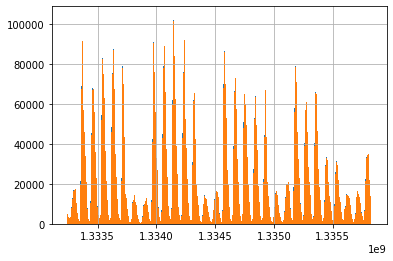

In [6]:
print(pd.to_datetime(data['startTime'].min(), unit='s'))
print(pd.to_datetime(data['endTime'].max(), unit='s'))
data['startTime'].hist(bins=1000)
data['endTime'].hist(bins=1000)

# Load in prefix and building information

In [7]:
prefix_lat_lon = pd.read_csv('prefix_lat_lon_name_category.csv')
legalPrefixes = prefix_lat_lon.prefix


In [8]:
print(prefix_lat_lon)

    prefix        lat        lon                             name  category
0      aaf  29.650275 -82.345720         Academic Advising Center     admin
1      adv  29.648792 -82.359303  Martin H. Levin Advocacy Center  academic
2      aer  29.643272 -82.348300       Mec. Aerospace Engineering  academic
3     aerv  29.643272 -82.348300       Mec. Aerospace Engineering  academic
4      alf  29.642948 -82.348636   Alfred A. Ring Tennis Pavilion    sports
..     ...        ...        ...                              ...       ...
189   weim  29.647761 -82.347342                      Wiemer Hall  academic
190  weimG  29.647761 -82.347342                      Wiemer Hall  academic
191  weimg  29.647761 -82.347342                      Wiemer Hall  academic
192     wm  29.648052 -82.346709                  Williamson Hall  academic
193    yon  29.649968 -82.347888                         Yon Hall  academic

[194 rows x 5 columns]


In [9]:
legalPrefixes.head()

0     aaf
1     adv
2     aer
3    aerv
4     alf
Name: prefix, dtype: object

# Clean the data

In [10]:
#prefixes found from our preprocessing function
#prefixesFound = np.unique(data.prefix)
prefixesFound = data['prefix'].unique()

In [11]:
#prefixes in the base table that don't match in the prefix table 
#TODO: more preprocessing to keep some of these?
unknownPrefixes = list(np.setdiff1d(prefixesFound, np.asarray(legalPrefixes)))

In [12]:
unknownPrefixes

['AP',
 'APc',
 'APe',
 'APf',
 'apopka',
 'apopka-win-lap',
 'b',
 'cba-ftlauderdale-win-lap',
 'ctx',
 'dairy-win-lap',
 'ecob',
 'escv',
 'flrec',
 'hotidf-win-lap',
 'irrec',
 'mowv',
 'ohl',
 'osbs-win-lap',
 'osbs-xxx-win-lap',
 'osbstr',
 'pep',
 'presAttic-wout-lap',
 'presStairs-win-lap',
 'rl',
 'rubygillhs-win-lap',
 'treeo-win-lap',
 'uic-win-lap',
 'unknown',
 'wrt']

In [13]:
#keep only valid prefixes (based on the prefix_lat_lon_name_category.csv table)
#removes about 400k rows?
data = data[~data['prefix'].isin(unknownPrefixes)]
data.shape

(18867555, 8)

In [14]:
# Keep only sessions longer than 10 seconds. Removes ~ 7 million receords. 
data = data[data['endTime']-data['startTime'] > 30]
print(data.shape)
data.head()

(9179058, 8)


,userIP,userMAC,APNAME,APMAC,startTime,endTime,deviceType,prefix
32,10.131.163.198,12544,gri101-wout-lap1231-1,00:1a:e2:10:ba:90,1333238683,1333238723,f,gri
41,10.132.190.177,33782,soc-temp-lap3502-5,88:f0:77:f2:67:a0,1333238693,1333238733,f,soc-temp-lap
42,10.132.251.191,85756,soc-temp-lap3502-2,88:f0:77:f2:5f:a0,1333238692,1333238736,f,soc-temp-lap
45,10.132.190.116,59170,soc-temp-lap3502-4,88:f0:77:f2:60:e0,1333238694,1333238738,f,soc-temp-lap
46,10.132.255.218,23629,soc-temp-lap3502-1,88:f0:77:f2:6b:80,1333238691,1333238741,unknown,soc-temp-lap


In [15]:
# Remove all records with users who have had fewer than 500 sessions 
data = data.groupby('userMAC').filter(lambda x : len(x)>500)
print(data.shape)

(3722227, 8)


## Get information about each user (useful for prediction later)

In [16]:
numUsers = data['userMAC'].unique().shape[0]

In [17]:
location_info = prefix_lat_lon[['prefix','name','category']]
location_info.head()

,prefix,name,category
0,aaf,Academic Advising Center,admin
1,adv,Martin H. Levin Advocacy Center,academic
2,aer,Mec. Aerospace Engineering,academic
3,aerv,Mec. Aerospace Engineering,academic
4,alf,Alfred A. Ring Tennis Pavilion,sports


## Association Matrix

In [18]:
data_start = data['startTime'].min()
data_end = data['endTime'].max()
step = 900
time_slots = np.arange(data_start, data_end, step)
#time_slots[-1] = data_end
print(time_slots.shape)

(2881,)


In [19]:
print(data_start, data_end)
print(time_slots)

1333238682 1335830719
[1333238682 1333239582 1333240482 ... 1335828882 1335829782 1335830682]


In [20]:
numLocations = location_info['name'].unique().shape[0]
print(numLocations)

137


In [21]:
def encounter_length(sa, ea, sb, eb):
    smax = sa if sa > sb else sb
    emin = ea if ea < eb else eb
    return emin - smax

In [22]:
from ncls import NCLS

In [39]:
name_prefix_codes =dict(zip(location_info.prefix, location_info.name))


#location_info[['prefix','name']].to_dict(orient='records') 
print(name_prefix_codes )
print(name_prefix_codes['faa'])

{'aaf': 'Academic Advising Center', 'adv': 'Martin H. Levin Advocacy Center', 'aer': 'Mec. Aerospace Engineering', 'aerv': 'Mec. Aerospace Engineering', 'alf': 'Alfred A. Ring Tennis Pavilion', 'and': 'Anderson Hall', 'ans': 'Animal Science', 'ansc': 'Animal Science Building C', 'apl': 'Aquatic Products Lab', 'arch': 'School of Architecture', 'aud': 'University Auditorium', 'bar': 'Bartram Hall', 'barB': 'Bartram Hall', 'bcf': 'BioContainment Facility', 'bcftr': 'Bio-Containment Facility', 'ben': 'Tolbert Hall', 'bgh': 'Bruton-Geer Hall', 'blk': 'Black Hall', 'bro': 'Broward Hall', 'broEastOIR-win-lap': 'Broward Hall', 'broEastOIR': 'Broward Hall', 'broOIR-EB': 'Broward Hall', 'broOIR': 'Broward Hall', 'brt': 'Bryant Space Science Center', 'brtb': 'Bryant Space Science Center', 'brttr': 'Bryant Space Science Center', 'bry': 'Bryan Hall', 'bwc': 'UF bookstore', 'bwcbookstore-win-lap': 'UF Bookstore', 'bwcbookstore': 'UF Bookstore', 'bwcg': 'UF Welcome Center', 'bwcp': 'UF Welcome Center

In [44]:
def generateAssociationMatrices():
    ass_mats = [0]*numUsers
    usermacs = [0]*numUsers
    inds = np.arange(0, len(time_slots))
    #print("indx", inds)
    #print(time_slots)
    int_tree = NCLS(time_slots.astype(np.int64), (time_slots + step).astype(np.int64), inds.astype(np.int64))

    counter = 0
    for user in data['userMAC'].unique():
        if (counter % 5 == 0):
            print("User ", counter, '/', numUsers)
        #ass_mat = np.zeroes((time_slots.shape[0], numLocations))
        ass_mat = pd.DataFrame(0, index=time_slots, columns=location_info['name'].unique())
        userSessions = data[data['userMAC'] == user]
        
        for session in userSessions.iterrows():
            start = session[1]['startTime']
            end =  session[1]['endTime']
            overlaps = int_tree.find_overlap(start, end)
            for o in overlaps:
                enc_len = encounter_length(start, end, o[0], o[1])
                prefix = session[1]['prefix']
                #sessionBuildingName = location_info[location_info['prefix'] == prefix] ['name']
                sessionBuildingName = name_prefix_codes[prefix]
                ass_mat.loc[o[0]][sessionBuildingName] += enc_len
        
        ass_mats[counter] = ass_mat
        usermacs[counter] = user
        counter+=1

    return ass_mats


In [45]:
mats = generateAssociationMatrices()
#Save association matrices (takes a long time to make them)
mats.to_pickle("./AssociationMatrices.pkl")

User  0 / 4567
User  5 / 4567
User  10 / 4567
User  15 / 4567
User  20 / 4567
User  25 / 4567
User  30 / 4567
User  35 / 4567
User  40 / 4567
User  45 / 4567
User  50 / 4567
User  55 / 4567
User  60 / 4567
User  65 / 4567
User  70 / 4567
User  75 / 4567
User  80 / 4567
User  85 / 4567
User  90 / 4567
User  95 / 4567
User  100 / 4567


In [57]:
# Normalize per row
def normalizeAssMat(mats):
    for i in range(0, len(mats)):
        mats[i] = mats[i].div(mats[i].sum(axis=1), axis=0)
        mats[i].fillna(value=0, inplace=True)
    return mats

In [58]:
normalizedMats = normalizeAssMat(mats[:5])
print(normalizedMats[1].head())

            aaf  adv  aer  aerv  alf  and  ans  ansc       apl  arch  ...  \
1333238682  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.000000   0.0  ...   
1333325082  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.205369   0.0  ...   
1333411482  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.018383   0.0  ...   
1333497882  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.129070   0.0  ...   
1333584282  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.385079   0.0  ...   

            van  wal  wei  weiclocktower-wout-lap  weiclocktower  weim  weimG  \
1333238682  0.0  0.0  0.0                0.000000            0.0   0.0    0.0   
1333325082  0.0  0.0  0.0                0.000000            0.0   0.0    0.0   
1333411482  0.0  0.0  0.0                0.004367            0.0   0.0    0.0   
1333497882  0.0  0.0  0.0                0.000000            0.0   0.0    0.0   
1333584282  0.0  0.0  0.0                0.059230            0.0   0.0    0.0   

            weimg   wm  yon  
1333238682    0.0  0

In [73]:
from sklearn.cluster import KMeans
numTimeSlots = len(time_slots)
numLocs = mats[0].shape[1]
X = [0]*100 #np.zeros((numUsers*numTimeSlots, numLocs))
for i in range(100):
    X[i] = mats[i]

In [74]:
X = np.asarray(X)
X.shape

(100, 2881, 137)

In [75]:
X = X.reshape(100*numTimeSlots, numLocs)
X.shape

(288100, 137)

In [63]:
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(X)

In [65]:
clusterCenters = kmeans.cluster_centers_
labels = kmeans.labels_ 
print(labels)

[0 0 0 ... 0 0 0]


In [91]:
MC_Cluster = labels.reshape(100, 2881).T
unique, counts = np.unique(labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4]),
 array([274384,   1951,   5033,   3433,   3299], dtype=int64))

In [70]:
#Try PCA on data
from sklearn.decomposition import PCA 
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X)
pca.explained_variance_ratio_.cumsum()


array([0.11083734, 0.19919747, 0.28420711])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2])
plt.show()

kmeans_pca = KMeans(n_clusters = 5, random_state=5).fit(X_pca)

In [41]:
#AMVD eq 1
NumTimeSlots, NumBuildings = normalizedMats[0].shape
mat1 = normalizedMats[0].to_numpy()
mat2 = normalizedMats[1].to_numpy()
a0 = mat1[0]

#np.sum(np.abs(a0 - mat2), axis=1) # eq 2 L1 norm

In [42]:
#find nearest neighbor of one row in A to all in B
np.zeros((NumTimeSlots,1))
for i in range(NumTimeSlots):
    argminDist = np.argmin(np.sum(np.abs(mat2 - mat1[i]), axis=1))


# Markov Chain

In [43]:
#predict for each user, where will they go next?
# *** predict across all users, where will an arbitrary person go next?

#Question: constrain the prediction of each user to be based only on where they've been before?
#Question: if not, assume that being in each building is equally likely?

#TODO: 5 min sampling of time bins
#TODO: 0 pad when they're not connected
#TODO: make transition matrix look pretty?

In [44]:
def MakeTransitionMatrix(history):
#      Input: DataArray - array of length N of integers that belong to 1 of C classes
#      Output: TransMat - is a right stochastic matrix (each row sums to 1)
#                         Each entry of TransMat(i,j) represents the probability
#                         of going from label i to label j
    NumTimeSteps  = len(history)
    NumComponents = np.max(history)
    
    #Pre-allocate transition matrix
    TransMat = np.zeros((NumComponents+1, NumComponents+1)) #+1 because 0-indexed

    for i in range(NumTimeSteps-1):
        Current = history[i]
        Next    = history[i+1]
        TransMat[Current, Next] = TransMat[Current, Next] + 1
        
    #Normalize rows
    TransMat = TransMat/np.sum(TransMat,1)[:,None] #broadcast vector for normalization by rows
    return TransMat

In [45]:
def FindNextState(TransMat, state, loc_dict, plotNextStateProb=False):
    #assume state is 0-indexed
    rand = np.random.random()
    
    #Make cdf of transitioning out of a given state
    cdf = np.cumsum(TransMat[state])    

    #find first state above random number on cdf
    nextState = np.where(cdf > rand)[0][0]
    
    if plotNextStateProb: #plot cdf and probability of transitioning
        StateSize = len(TransMat)
        plt.figure(dpi=100)
        plt.plot(np.insert(cdf, 0, 0))
        plt.title("Cumulative Distribution function" + " - Chose state " + str(nextState) + ' ' + loc_dict[nextState])
        plt.axhline(rand, c='red')
        for i in range(StateSize):
            plt.axvline(i, c='k')
        plt.show()
    
    return nextState

In [46]:
def PredictFutureSteps(TransMat, MostRecentState, bldg_dict, NumFutureSteps, PlotCDF=False):
    nextStates  = []
    nextBldgs   = []
    currState   = MostRecentState
    for i in range(NumFutureSteps):
        nextState = FindNextState(TransMat, currState, bldg_dict, PlotCDF)
        #print("\nNext state", bldg_dict[nextState])
        nextStates.append(nextState)
        nextBldgs.append(bldg_dict[nextState])
        currState = nextState

    #print("Next states array:", nextStates)
    #print("Next buildings array:", nextBldgs)
    return nextStates, nextBldgs

## Toy example for Markov Chain

In [47]:
# demo of a Markov chain predictor

#Toy data
bldg_dict = {0: 'Not Connected', 
             1: 'hub',
             2: 'reitz',
             3: 'lib west'}

personHistory = np.array([0,0,0,1,1,2,2,1,2,3,2,3,2,3,1,2,0,1,0])

#Make transition matrix
TransMat = MakeTransitionMatrix(personHistory)
print("TransMat:\n", TransMat)

#Predict future steps based on their most recent history
NumFutureSteps  = 5
MostRecentState = personHistory[-1]
nextSteps, nextBldgs = PredictFutureSteps(TransMat, MostRecentState, bldg_dict, NumFutureSteps, PlotCDF=False)
nextSteps, nextBldgs

TransMat:
 [[0.5        0.5        0.         0.        ]
 [0.2        0.2        0.6        0.        ]
 [0.16666667 0.16666667 0.16666667 0.5       ]
 [0.         0.33333333 0.66666667 0.        ]]


([1, 2, 3, 1, 2], ['hub', 'reitz', 'lib west', 'hub', 'reitz'])

In [48]:
#map the buildings to an index
bldg_dict = {i: location_info['prefix'].iloc[i] for i in range(len(location_info))}
keyOfBldg = list(bldg_dict.values()).index('aer')
#TODO: apply MC to actual data